## Setup: Only for Google Colab

NOTE: If you're developing locally, skip to Section 0 below. Otherwise, follow these steps to fetch required modules from the Github repository and install required packages.

Let's start by downloading the helper modules from the [BAMB2024 Github repository](https://github.com/bambschool/BAMB2024). Just execute the code in the cells below and see if it populates the modules locally and ensure that there are no installation errors.

In [1]:
# define the github path and authorization token
RAW_GITHUB_PATH = 'https://raw.githubusercontent.com/bambschool/BAMB2024/main/day2_reinforcement_learning/part1_rl_basics/'

# define the list of files to be downloaded
files = ['agents.py', 'environments.py', 'plots.py', 'simulate.py']

for file in files:
    !wget -O {file} "{RAW_GITHUB_PATH}{file}"

--2025-07-17 09:39:43--  https://raw.githubusercontent.com/bambschool/BAMB2024/main/day2_reinforcement_learning/part1_rl_basics/agents.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3272 (3.2K) [text/plain]
Saving to: ‘agents.py’

agents.py           100%[===================>]   3.20K  --.-KB/s    in 0s      

2025-07-17 09:39:43 (53.0 MB/s) - ‘agents.py’ saved [3272/3272]

--2025-07-17 09:39:43--  https://raw.githubusercontent.com/bambschool/BAMB2024/main/day2_reinforcement_learning/part1_rl_basics/environments.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent,

Check that the files `agents.py`, `environments.py`, `plots.py`, and `simulate.py` are now in your Colab workspace on the left sidebar. We can't import anything yet because most modules need at least one external package which we have not yet installed. Let's install them.

In [1]:
!pip install wheel setuptools pip --upgrade
!pip install swig seaborn
!pip install gymnasium[box2d]
!pip install minigrid

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'box2d-py' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'box2d-py'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379431 sha256=b8a22ef63891099b9d3ada20548abd3b2f5e489154686e1c5ee6f5ca04937e87
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


To render the videos in Colab, you'll need something [like this](https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab) (but we have to code the render function again, so I'm skipping it for now):

```python
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
```

Unfortunately, this needs us to modify our modules specifically to render videos on Colab as in [this post](https://stackoverflow.com/questions/50107530/how-to-render-openai-gym-in-google-colab). For now, we're going to skip it.

## 0. Structuring your Agents' and Environments' classes

In this tutorial, we'll learn how to implement reinforcement learning (RL) agents and environments following the structure of the OpenAI Gym (now Gymnasium by Farama Foundation) API. This standardized approach will help you organize your code and make it easier to extend to more complex environments later. Take a look at the figure below to refresh your memories on how Agents interact with Environments:

<div>
<img src="https://www.scribbr.com/wp-content/uploads/2023/08/the-general-framework-of-reinforcement-learning.webp" width="500">
</div>

### 0.1. Environment Structure

Let's start by looking at the basic structure of an environment. You should always aim to follow the [Gym API](https://github.com/Farama-Foundation/Gymnasium?tab=readme-ov-file#api) for any new tasks you define for your projects. Here's what it looks like:

```python
class Environment:
    def step(self, action) -> tuple:
        # Implement the dynamics of the environment
        # Returns: next_state, reward, terminated, truncated, info
        pass

    def reset(self) -> tuple:
        # Reset the environment to its initial state
        # Returns: initial_state, info
        pass
```

The `step` method is crucial. It takes an action as input and returns four values:

- `next_state`: The state of the environment after taking the action
- `reward`: The reward received for taking the action
- `terminated`: A boolean indicating whether the agent has reached the terminal state
- `truncated`: A boolean indicating whether the episode is truncated, e.g. prematurely ended
- `info`: A dictionary containing additional information (optional)

The `reset` method initializes a new episode and returns the initial state.

### 0.2. Agent Structure
Now, let's look at the basic structure of an agent:


```python
class Agent:
    def __init__(self, action_space: int, state_space: int) -> None:
        self.action_space = action_space
        self.state_space = state_space

    def act(self, state) -> int:
        # Implement the agent's policy
        # Returns: chosen action
        pass

    def update(self, state, action, reward, next_state, next_action=None) -> None:
        # Update the agent's internal parameters
        pass
```

The `act` method implements the agent's policy, deciding which action to take given the current state. The `update` method is used to update the agent's internal parameters based on its experience. As opposed to the `Environment` class where you should follow the `step` and `reset` naming conventions, you can freely choose what you like for the `Agent`. In this course, however, we will follow the convention defined above.

### 0.3. Training Function

To tie everything together, we'll use a training function. This function will run episodes, allowing the agent to interact with the environment and learn from its experiences.

```python
def train_agent(agent: Agent, env: Environment, num_episodes: int = 100):
    # initialize list to collect data (here: only rewards)
    reward_history = []

    for episode in range(num_episodes):
        # fetch state from the environment
        state, _ = env.reset()
        
        # initialize episode's reward and termination conditions
        total_reward = 0
        done = False

        while not done:
            # agent acts acc. to its policy given environment's state
            action = agent.act(state)

            # environment returns next state, reward, and other info
            next_state, reward, done, _, info = env.step(action)

            # agent uses this info to learn
            agent.update(state, action, reward, next_state)

            # update state and reward
            state = next_state
            total_reward += reward
        
        # when episode ends, record the total reward obtained
        reward_history.append(total_reward)

    return reward_history
```

This function does the following:
- Runs for a specified number of episodes
- For each episode:
  - Resets the environment
  - Lets the agent choose actions and interact with the environment
  - Updates the agent based on the observed transitions
  - Keeps track of the total reward for the episode
- Returns a history of rewards for each episode

In [ ]:
#

# 1. Explore a simple Environment

Let's start by exploring the environment. We will use the `gym` library's built-in `FrozenLake-v1` environment for this tutorial. First, let's create an instance of this environment and see what it looks like.

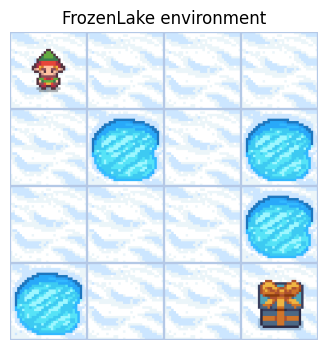

In [4]:
import gymnasium as gym
from plots import plot_frozenlake_environment

# create the FrozenLake environment from gym
env = gym.make('FrozenLake-v1', render_mode="rgb_array")

# plot the environment
plot_frozenlake_environment(env)

### 1.1. Observation and action space

Next, let's examine the observation and action spaces. The observation space represents the environment's state, and the action space represents the possible actions an agent can take.

In [3]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Discrete(16)
Action space: Discrete(4)


### 1.2. Making sense of environment's variables

If we check the [documentation for the FrozenLake environment](https://gymnasium.farama.org/environments/toy_text/frozen_lake/), we see the following:

#### 1.2.1. Action Space

The action shape is (1,) in the range {0, 3} indicating which direction to move the player.

- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

#### 1.2.2. Observation Space

The observation is a value representing the player’s current position as current_row * nrows + current_col (where both the row and col start at 0). For example, the goal position in the 4x4 map can be calculated as follows: 3 * 4 + 3 = 15. The number of possible observations is dependent on the size of the map. The observation is returned as an int().

#### 1.2.3. Starting State

The episode starts with the player in state [0] (location [0, 0]).

#### 1.2.4 Rewards

Reward schedule:

- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

#### 1.2.5. Episode End

The episode ends if the following happens:

- Termination:
  1. The player moves into a hole.
  2. The player reaches the goal at max(nrow) * max(ncol) - 1 (location [max(nrow)-1, max(ncol)-1]).
- Truncation (when using the time_limit wrapper):
  1. The length of the episode is 100 for 4x4 environment, 200 for FrozenLake8x8-v1 environment.

### 1.3. Train a random agent

Before moving on to the `QLearningAgent`, let's start with a simpler agent: the `RandomAgent`. This agent will take random actions in each step. It's a good starting point to understand the basics of reinforcement learning agents. Take a look at the code first and then let's import the RandomAgent class from the `agents` module.

In [5]:
from agents import RandomAgent
from simulate import train_agent

# create a random agent
random_agent = RandomAgent(action_space=env.action_space.n, state_space=env.observation_space.n)

# Train the agent and record data
random_agent_rewards = train_agent(random_agent, env, num_episodes=5_000)

Episode 4999 reward: 0.0
Training completed


#### 1.3.1. Plot the performance of RandomAgent

Now, let's plot the performance of our RandomAgent to see if it learned anything.

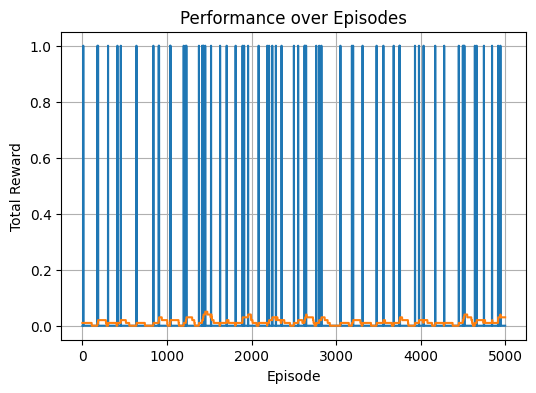

In [6]:
from plots import plot_performance

plot_performance(random_agent_rewards)

#### 1.3.2. Inspect the behavior

To get a better intuition of what's going on, let's render the agent in the environment. You don't need to write the code, it's already implemented as a function `render_agent_performance` in `simulate.py`. We'll import it from there. Note that it's always a good idea to create a separate environment for rendering.

In [7]:
from simulate import render_agent_performance

# create a new environment to see agent's performance
render_env = gym.make("FrozenLake-v1", render_mode="human")

render_agent_performance(agent=random_agent, env=render_env, num_episodes=3)

Episode 1 completed with reward 0.0
Episode 2 completed with reward 0.0
Episode 3 completed with reward 0.0


In [ ]:
###################################################################

## 2. Implement a Q-Learning agent

In this section, we'll implement a Q-Learning agent with an $\epsilon$-greedy policy. As a reminder, here is the update rule for Q-Learning:

- $q(s,a) \leftarrow q(s,a) + \alpha \cdot \delta$, where
- $\delta = r(s,a) + \gamma \cdot \max_{a'} q(s', a') - q(s,a)$


In the equations above, $\delta$ is the TD (temporal difference) prediction error, which is the difference of two terms, the expected return after taking action $a$ from state $s$ minus the current prediction or estimate:

- The *target* or *expected future return*:
  - $r(s,a) + \gamma \cdot \max_{a'} q(s', a')$
- The current *prediction*:
  - $q(s,a)$

The $\epsilon$-greedy policy is pretty simple. For a state $s$, the policy $\pi(a|s)$ should be as follows:
- Draw a number $x\sim U[0,1]$, i.e., uniformly at random between 0 and 1
- If $x > \epsilon$:
  - $a = \argmax_{a'} q(s,a')$ (pick action that maximizes q-value)
- otw:
  - $a$ ~ {0, 1} (pick a random action)

### 2.1. TO DO: Code a Q-Learning Agent

In the cell below, fill in the `act` and `update_q_table` methods.

Tip:
- if you are lost, check out the `RandomAgent` and `SARSAAgent` from `agents.py`
- try not to check the final solution - the class `QLearningAgent` - which is also present in `agents.py`

In [9]:
# Q-Learning Agent
import numpy as np

class QLearningAgent:
    def __init__(self, action_space, state_space) -> None:
        # set up q table with correct dimensions
        self.action_space = action_space
        self.state_space = state_space
        self.q_table = np.zeros(shape=(state_space, action_space))

        # initialize agent's parameters
        self.gamma = 0.99
        self.alpha = 0.1
        self.epsilon = 1
        self.num_episodes_decay = 4_000
        self.epsilon_decay = self.epsilon / self.num_episodes_decay

        # set up a random number generator
        self.rng = np.random.default_rng()
        def act(self, state) -> int:
          if self.rng.random() < self.epsilon:
            return self.rng.integers(0, self.action_space)  # explore
          else:
            return int(np.argmax(self.q_table[state]))      # exploit

    def update_epsilon(self) -> None:
        # slowly decrease epsilon as agent learns
        if self.epsilon - self.epsilon_decay > 0:
            self.epsilon -= self.epsilon_decay

    def update_q_table(self, state, action, reward, next_state) -> None:
      current_q_value = self.q_table[state][action]
      max_future_q = np.max(self.q_table[next_state])  # max_a' Q(s', a')
      new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_future_q - current_q_value)
      self.q_table[state][action] = new_q_value



### 2.2. Things to think about

- What is the `update_epsilon` method is doing?
- What happens to performance (Section 2.5 below) if you reduce or increase the `num_episodes_decay`?
  - Try increasing it more than `num_episodes`.
  - Try decreasing it.
    - Does anything happen if you decrease it to a very small value, say less than 10?
    - Simulate multiple times to be sure. Do you always converge?

Keep your answers in mind and try the same manipulations for part 3 (CartPole).

### 2.3. Special FrozenLake environment

This time, we will activate slippery mode with a specific randomly-generated map to see how clever Q-Learning really is.

#### Slippery mode

`is_slippery=True`: If true the player will move in intended direction with probability of 1/3 else will move in either perpendicular direction with equal probability of 1/3 in both directions.

For example, if action is left and is_slippery is True, then:

- P(move left)=1/3
- P(move up)=1/3
- P(move down)=1/3

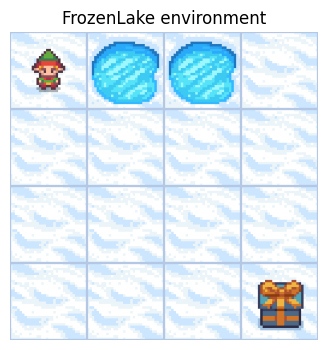

In [ ]:
# from environments import FrozenLakeEnvironment
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
from plots import plot_frozenlake_environment

# define map size
map_size = 4

# Define the FrozenLake environment
# env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
env = gym.make(
            "FrozenLake-v1",
            is_slippery=True,
            render_mode="rgb_array",
            desc=generate_random_map(size=map_size, p=0.9, seed=420)
        )

# plot the environment's map
plot_frozenlake_environment(env)

### 2.4. Train the QLearning agent

In this section, we will see the power of Q-Learning. Let's simulate it in the FrozenLake environment like we simulated the RandomAgent.

NOTE: Remove QLearningAgent from the first line in the cell below as it imports the QLearningAgent agent from the library. You should use the class *you* defined for QLearningAgent.

In [ ]:
from agents import QLearningAgent, RandomAgent
from simulate import train_agent

# define the agents
random_agent = RandomAgent(env.action_space.n, env.observation_space.n)
q_learning_agent = QLearningAgent(env.action_space.n, env.observation_space.n)

# Train the agents and record data
print("Training RandomAgent")
random_agent_rewards = train_agent(random_agent, env, num_episodes=5_000)

print("\nTraining QLearningAgent")
q_agent_rewards = train_agent(q_learning_agent, env, num_episodes=5_000)

Training RandomAgent
Episode 4999 reward: 0.0
Training completed

Training QLearningAgent
Episode 4999 reward: 1.0
Training completed


### 2.5. Plot the performance

Now let's plot the performance of our agent and the learned policy. We will also check the performance against the random agent.

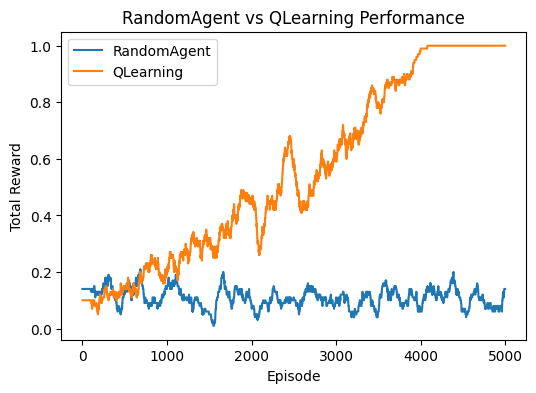

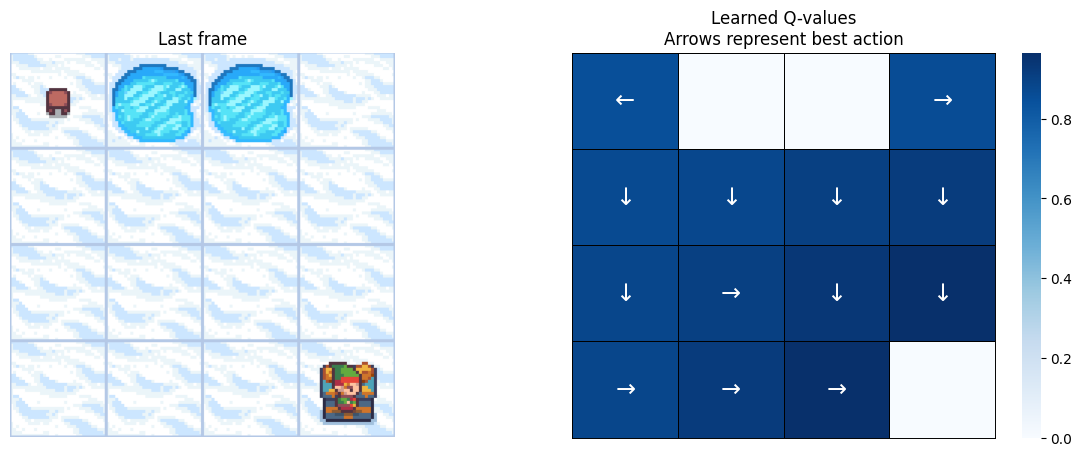

In [ ]:
from plots import plot_performance_comparison, plot_q_values_map

plot_performance_comparison(random_agent_rewards, 'RandomAgent', q_agent_rewards, 'QLearning')
plot_q_values_map(q_learning_agent.q_table, env, map_size)

### 2.6. Inspect agent's behavior

It's not only more fun but also insightful to look at the agent's behavior live. Let's do that.

In [ ]:
# make a new environment for rendering, but with the same seed (map)
render_env = gym.make(
            "FrozenLake-v1",
            is_slippery=True,
            render_mode="human",
            desc=generate_random_map(size=map_size, p=0.9, seed=420)
        )

# render the agent's behavior
render_agent_performance(q_learning_agent, render_env)

Episode 1 completed with reward 1.0
Episode 2 completed with reward 1.0
Episode 3 completed with reward 1.0


### 2.7. Questions

- Why does the agent the QLearning agent go left in the first state, i.e. top-left of the map?
- Does this behavior change if you set `is_slippery=False` while creating the environment?

- Create a much bigger map, for instance, by setting `map_size=16`. Then change the `gamma` or the discount parameter for the `QLearningAgent` to something very small (less than 0.1). What happens?

In [ ]:
###############################################################################

## 3. The Cliff Walking environment

Next, let's simulate one of the examples Maria showed you in class: The Cliff Walking environment.

![CliffWalk](https://gymnasium.farama.org/_images/cliff_walking.gif)

One of the things you were shown in class was that Q-Learning learns the optimal path whereas SARSA learns the safer path.

<div>
<img src="https://raw.githubusercontent.com/bambschool/BAMB2024/main/day2_reinforcement_learning/part1_rl_basics/assets/sarsa_vs_qlearning_cliffwalk.png" width="500">
</div>

### 3.1. TO DO: Code a SARSA Agent

Just like in Section 2.1, where you wrote the code for a QLearning agent, here, we will code a SARSA agent. In the cell below, fill in the `act` and `update_q_table` methods. The `act` method could be the same  $\epsilon$-greedy policy that you used for Q-Learning. All you need to do is copy the code.

As a reminder, here is the update rule for SARSA:

- $q(s,a) \leftarrow q(s,a) + \alpha \cdot \delta$, where
- $\delta = r(s,a) + \gamma \cdot q(s', a') - q(s,a)$

Tips:
- The agent hasn't taken the next action, $a'$. Is there a way you could still access it?
- The final solution - the class `SARSAAgent` - is present in `agents.py`. See how your code matches up with it.

In [ ]:
class SARSAAgent:
    def __init__(self, action_space: int, state_space: int) -> None:
        # set up q table with correct dimensions
        self.action_space = action_space
        self.state_space = state_space
        self.q_table = np.zeros(shape=(state_space, action_space))

        # initialize agent's parameters
        self.gamma = 0.99
        self.alpha = 0.1
        self.epsilon = 1
        self.epsilon_decay = self.epsilon / 4_000

        # set up a random number generator
        self.rng = np.random.default_rng()

    def act(self, state) -> int:
        # TODO: Implement epsilon-greedy action policy
        # Currently, it is a random policy
        # Feel free to copy it from earlier
        return self.rng.integers(0, self.action_space)

    def update_epsilon(self) -> None:
        # slowly decrease epsilon as agent learns
        if self.epsilon - self.epsilon_decay > 0:
            self.epsilon -= self.epsilon_decay

    def update_q_table(self, state, action, reward, next_state) -> None:
        # TODO: Implement the SARSA update rule
        # q(s, a) can be accessed by self.q_table[state][action]
        pass

### 3.2. Train the SARSA agent (and a QLearning agent)

In this section, we will see how modular and useful our code is. Now only will we simulate the SARSA agent you just defined, but also the Q-Learning agent from the previous section.

NOTE: Remove `QLearningAgent` and `SARSAAgent` from the second line in the cell below as it imports them from the library. You should use the classes *you* defined (which should run as long as you ran the cells where you defined them).

In [ ]:
import gymnasium as gym
from agents import QLearningAgent, SARSAAgent

env = gym.make("CliffWalking-v1")
q_agent = QLearningAgent(action_space=env.action_space.n, state_space=env.observation_space.n)
sarsa_agent = SARSAAgent(action_space=env.action_space.n, state_space=env.observation_space.n)

# Train the agents and record data
print("Training Q-Learning Agent")
q_agent_rewards = train_agent(q_agent, env, num_episodes=5_000)

print("\nTraining SARSA Agent")
sarsa_agent_rewards = train_agent(sarsa_agent, env, num_episodes=5_000)

Training Q-Learning Agent
Episode 4999 reward: -13783
Training completed

Training SARSA Agent
Episode 4999 reward: -17915
Training completed


### 3.3. Inspect the behavior

Does SARSA really take the safer path and Q-Learning really take the optimal path? Let's find out by rendering the Q Learning agent first.

In [ ]:
from simulate import render_agent_performance

render_env = gym.make('CliffWalking-v1', render_mode="human")
render_agent_performance(agent=q_agent, env=render_env, num_episodes=1)

Episode 1 completed with reward -1
Episode 2 completed with reward -1
Episode 3 completed with reward -1


Now let's check what path SARSA takes.

In [ ]:
render_agent_performance(agent=sarsa_agent, env=render_env, num_episodes=1)

Episode 1 completed with reward -1


In [ ]:
##############################################################

Finally, let's see just how useful it is when we define the agents and environments with their proper structure (Section 0). Without writing any additional code, let's see if we can simply plug in our agent to a classic control problem.

## 4. The Cartpole problem

The [CartPole problem](https://gymnasium.farama.org/environments/classic_control/cart_pole/) consists of a pole attached by an un-actuated joint to a cart, which moves along a frictionless one-dimensional track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

![CartPole](https://gymnasium.farama.org/_images/cart_pole.gif)

> NOTE:
> To use it with our agent, we need to discretize the state because it is continuous. Don't worry, you don't have to implement that. It's already present in `environments.py`. Feel free to take a look if you're interested; otherwise ignore it.

### 4.1. Create the environment and the agent

Let's start by creating the environment and the agent. You should use the QLearning agent you defined above instead of importing the pre-coded one from agents as is currently done in the cell below.

In [ ]:
from agents import QLearningAgent
from environments import CartPoleEnvironment

# Create the environment and agent
env = CartPoleEnvironment()
agent = QLearningAgent(action_space=env.action_space.n, state_space=env.state_space_size)

### 4.2. Train the agent

Now let's train the agent. We are going to use the same training function we had used before.

In [ ]:
from simulate import train_agent

# train agent and record collected rewards
reward_history = train_agent(agent=agent, env=env, num_episodes=6_000)

Episode 4094 reward: 500.0
Environment solved in 4095 episodes!

Training completed


### 4.3. Plot the performance

Did you notice the rewards increasing over episodes in the output above? Let's plot it to see what actually happened.

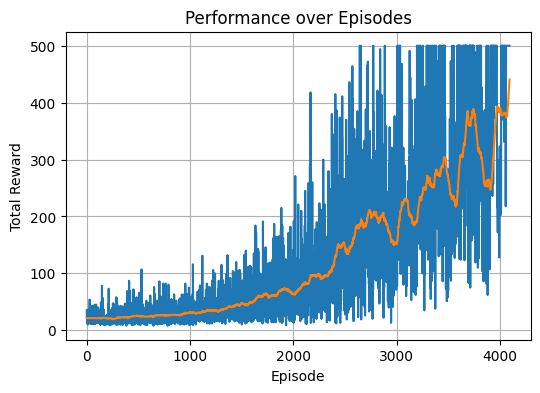

In [ ]:
from plots import plot_performance

plot_performance(reward_history)

### 4.4. Inspect the behavior

As before, it's much better to see the agent in action. Let's do that. Remember, we need to define a new environment with the argument `render_mode="human"`.

In [ ]:
from environments import CartPoleEnvironment
from simulate import render_agent_performance

render_env = CartPoleEnvironment(render_mode="human")
render_agent_performance(agent, render_env, num_episodes=1)

Episode 1 completed with reward 1.0
